# Mental Health Risk Detection – Data Exploration

This notebook explores and analyzes the datasets used for training the DistilBERT risk classification model.

Datasets Used:
- mental_health.csv (https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health)
- Suicide_Detection.csv (https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch)

Objective:
- Standardize labels
- Analyze class distribution
- Inspect text length variation
- Prepare data understanding before model training


In [3]:
import pandas as pd

# Load datasets
df_old = pd.read_csv("../data/raw/mental_health.csv")
df_new = pd.read_csv("../data/raw/Suicide_Detection.csv")

print("Old Dataset Shape:", df_old.shape)
print("New Dataset Shape:", df_new.shape)

print("\nOld Dataset Preview:")
display(df_old.head())

print("\nNew Dataset Preview:")
display(df_new.head())


Old Dataset Shape: (53043, 3)
New Dataset Shape: (232074, 3)

Old Dataset Preview:


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety



New Dataset Preview:


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
# Standardize column names
df_old = df_old.rename(columns={'statement': 'text', 'status': 'risk_label'})

old_mapping = {
    'Suicidal': 'High',
    'Depression': 'Moderate',
    'Anxiety': 'Moderate',
    'Stress': 'Moderate',
    'Bi-Polar': 'Moderate',
    'Personality Disorder': 'Moderate',
    'Normal': 'Low'
}

df_old['risk_label'] = df_old['risk_label'].map(old_mapping)
df_old = df_old[['text', 'risk_label']]

df_new = df_new.rename(columns={'class': 'risk_label'})
df_new['risk_label'] = df_new['risk_label'].map({
    'suicide': 'High',
    'non-suicide': 'Low'
})
df_new = df_new[['text', 'risk_label']]

print("Old Dataset Label Distribution:")
print(df_old['risk_label'].value_counts())

print("\nNew Dataset Label Distribution:")
print(df_new['risk_label'].value_counts())


Old Dataset Label Distribution:
risk_label
Moderate    21961
Low         16351
High        10653
Name: count, dtype: int64

New Dataset Label Distribution:
risk_label
High    116037
Low     116037
Name: count, dtype: int64


In [5]:
# Combine datasets
combined_df = pd.concat([df_old, df_new], ignore_index=True).dropna()

print("Combined Dataset Shape:", combined_df.shape)

print("\nFinal Label Distribution:")
print(combined_df['risk_label'].value_counts())


Combined Dataset Shape: (280901, 2)

Final Label Distribution:
risk_label
Low         132380
High        126689
Moderate     21832
Name: count, dtype: int64


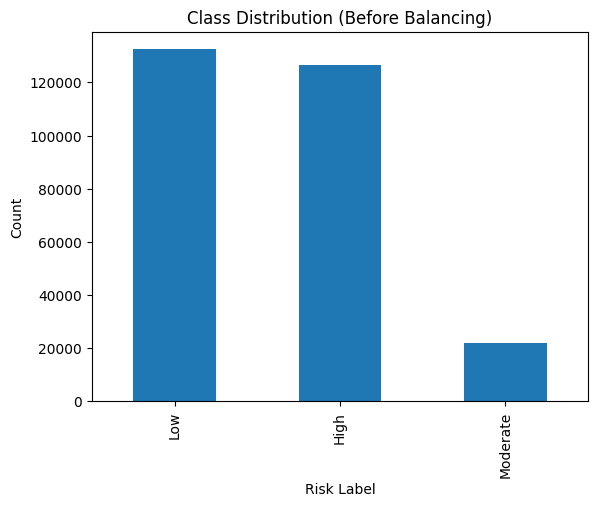

In [6]:
import matplotlib.pyplot as plt

combined_df['risk_label'].value_counts().plot(
    kind='bar',
    title='Class Distribution (Before Balancing)'
)

plt.xlabel("Risk Label")
plt.ylabel("Count")
plt.show()


## Class Imbalance Observation

The dataset shows imbalance:

- Low and High risk classes dominate the dataset.
- Moderate class is significantly smaller.

To prevent model bias toward majority classes, balanced sampling was applied during training.


In [7]:
# Simulate balancing strategy used in training

df_low = combined_df[combined_df['risk_label'] == 'Low'].sample(n=15000, random_state=42)
df_high = combined_df[combined_df['risk_label'] == 'High'].sample(n=15000, random_state=42)
df_mod = combined_df[combined_df['risk_label'] == 'Moderate']

balanced_df = pd.concat([df_low, df_mod, df_high])

print("Balanced Dataset Distribution:")
print(balanced_df['risk_label'].value_counts())


Balanced Dataset Distribution:
risk_label
Moderate    21832
Low         15000
High        15000
Name: count, dtype: int64


## Tokenization & Model Preparation (DistilBERT)

The balanced dataset is tokenized using the DistilBERT tokenizer.
This converts text into numerical representations suitable for Transformer-based classification.

Training is performed using:
- DistilBERT (distilbert-base-uncased)
- Sequence classification head
- 3 output classes (Low, Moderate, High)
- Mixed precision (FP16) for GPU efficiency


# System Architecture Overview

The Mental Health Risk Detection System follows a hybrid AI pipeline combining
classification models and generative AI.

---

## Processing Flow

User Text  
↓  
Risk Classification Model (DistilBERT – 3 Class)  
→ Outputs: Low / Moderate / High + Confidence Score  
↓  
Symptom Detection Model (Multi-Label DistilBERT)  
→ Detects emotional indicators such as:
- Hopelessness
- Sadness
- Loneliness
- Suicide Intent
- Worthlessness
↓  
Escalation & Safety Logic  
→ Suicide phrase override  
→ Probability threshold escalation  
→ Priority mapping  
↓  
Severity Estimation  
→ Mild / Moderate / Severe Distress  
↓  
Gemini 2.5 Flash Lite  
→ Generates empathetic explanation  
↓  
Final JSON Response:
- Risk Label  
- Risk Score  
- Priority  
- Detected Symptoms  
- Severity  
- Psychological Pattern  
- AI Explanation  
- Emergency Support (if Critical)

---

## Model Components

1. **Primary Risk Model**
   - Architecture: DistilBERT (Sequence Classification)
   - Classes: Low, Moderate, High
   - Softmax probability scoring
   - Mixed precision (FP16) training

2. **Symptom Profiling Model**
   - Architecture: DistilBERT (Multi-Label Classification)
   - Uses sigmoid activation
   - Threshold-tuned per symptom

3. **Safety Layer**
   - Strong phrase override
   - Suicide probability escalation
   - Automatic crisis support trigger

---

## Design Philosophy

This system is designed as:

- An AI-assisted early warning system
- Not a medical diagnosis tool
- Focused on triage support & explainability
- Built with safety-first escalation logic


## Model Evaluation Metrics

After training the DistilBERT risk classification model, the following evaluation
metrics were used to measure performance:
- Accuracy
- Precision
- Recall
- F1 Score


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import numpy as np

# Prepare small sample for evaluation demonstration
sample_df = balanced_df.sample(n=2000, random_state=42)

le = LabelEncoder()
sample_df['label'] = le.fit_transform(sample_df['risk_label'])

X_train, X_test, y_train, y_test = train_test_split(
    sample_df['text'], sample_df['label'], test_size=0.2, random_state=42
)

# Load trained model
model_path = "../artifacts/risk_model_v1"
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

model.eval()

# Tokenize test data
inputs = tokenizer(
    list(X_test),
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=128
)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).numpy()

print("Evaluation Metrics (Sample Test Set):\n")
print(classification_report(y_test, predictions))


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Evaluation Metrics (Sample Test Set):

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       136
           1       0.94      0.96      0.95        95
           2       0.90      0.95      0.93       169

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.92       400



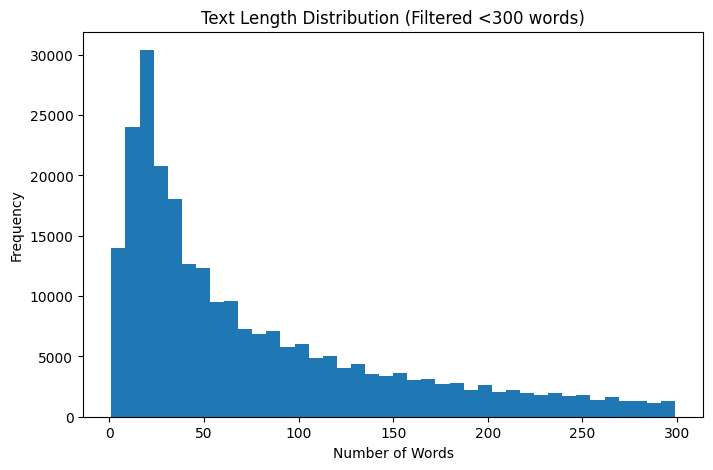

In [12]:
# Remove extreme outliers for clearer visualization
filtered_lengths = combined_df["text_length"][combined_df["text_length"] < 300]

plt.figure(figsize=(8,5))
plt.hist(filtered_lengths, bins=40)
plt.title("Text Length Distribution (Filtered <300 words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


### Observation

Most user inputs fall below 100–150 words.
The 128-token limit was selected to balance:
- Context retention
- GPU efficiency
- Training stability

Long outliers exist but represent a small fraction of total samples.


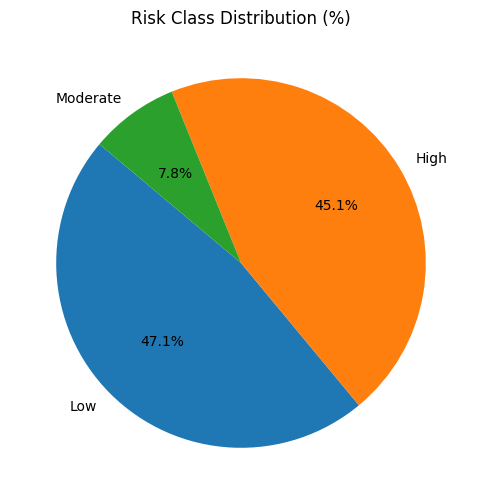

In [13]:
class_counts = combined_df['risk_label'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    class_counts,
    labels=class_counts.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Risk Class Distribution (%)")
plt.show()


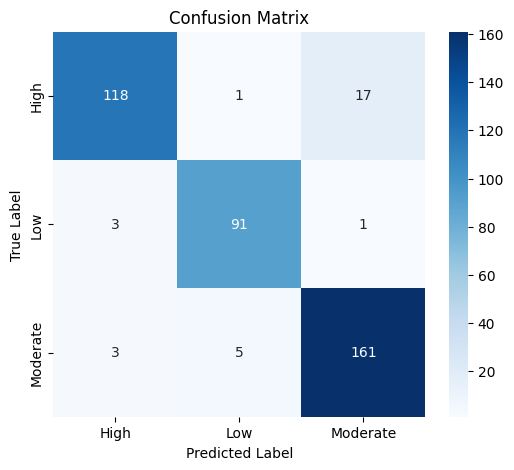

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Confusion Matrix Interpretation

The confusion matrix evaluates the classification performance across all three risk levels.

Observations:

- **High Risk:** Majority correctly classified, with minor confusion toward Moderate.  
- **Low Risk:** Strong separation from High and Moderate classes.  
- **Moderate Risk:** Well predicted despite being the minority class in the original dataset.  

The matrix shows balanced classification behavior, confirming:

- No major class collapse  
- Strong separation between Low and High risk  
- Controlled overlap between High and Moderate (expected due to semantic similarity)

This supports the overall model performance:
- Accuracy ≈ 93%
- Macro F1 ≈ 0.93

The model demonstrates reliable triage-level classification performance.
